# Load Packages and Set Plot Formats

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from math import floor, ceil
from pylab import rcParams

%matplotlib inline

ModuleNotFoundError: No module named 'tensorflow'

In [2]:
#sns package great for charts, here we set the formatting of the plot area 
sns.set(style='ticks', palette='Spectral', font_scale=1.5)

#colors used in the plot
material_palette = ["#4CAF50", "#2196F3", "#9E9E9E", "#FF9800", "#607D8B", "#9C27B0"]

#defining what colors will be used in the plots 
sns.set_palette(material_palette)

#setting the figure size of the plots 
rcParams['figure.figsize'] = 16, 8

#setting the plot seed 
plt.xkcd()
random_state = 42
np.random.seed(random_state)
tf.set_random_seed(random_state)

In [3]:
pwd

'C:\\Users\\wp725bm'

# Load IRS data (changed some to random continuous variables)

# Demo Profiling of Variables

In [7]:
nn_org_df = pd.read_csv("C:\\Users\\caridza\\Desktop\\pythonScripts\\TensorFlownn_test.csv", sep=",")
nn_org_df.columns.values

array(['Profile_Number', 'Client_Type_of_Customer',
       'Accountholder_is_of_a_Riskier_Legal_Entity',
       'Account_Associated_with_High_Risk_Business_Type',
       'Geographic_Attributes_All_Domestic',
       'High_Risk_Geography_Associated_with_Account',
       'Length_of_Relationship',
       'Prime_Brokerage_Service_Provided_to_Client',
       'Type_of_Custodial_Relationship',
       'High_Risk_Unknown_Source_of_Funds_Wealth',
       'Potential_Match_on_Watchlist', 'Trade_Surveillance_Referral',
       'Foreign_Affiliate_Routing_Customers_Trades_through_CSSU_Omnibus_Account',
       'Evidence_of_OTC_Trades',
       'Evidence_of_Trades_on_Unapproved_Exchange',
       'Evidence_of_Trades_in_Low_Price_Microcap_Securities',
       'Evidence_of_DVPRVP', 'Evidence_of_Direct_Market_Access',
       'Evidence_of_International_Wires', 'Evidence_of_3rd_Party_Wires',
       'Anomalous_Account_Administration', 'Potential_Securities_Fraud',
       'Potential_Market_Manipulation_Fraud',
    

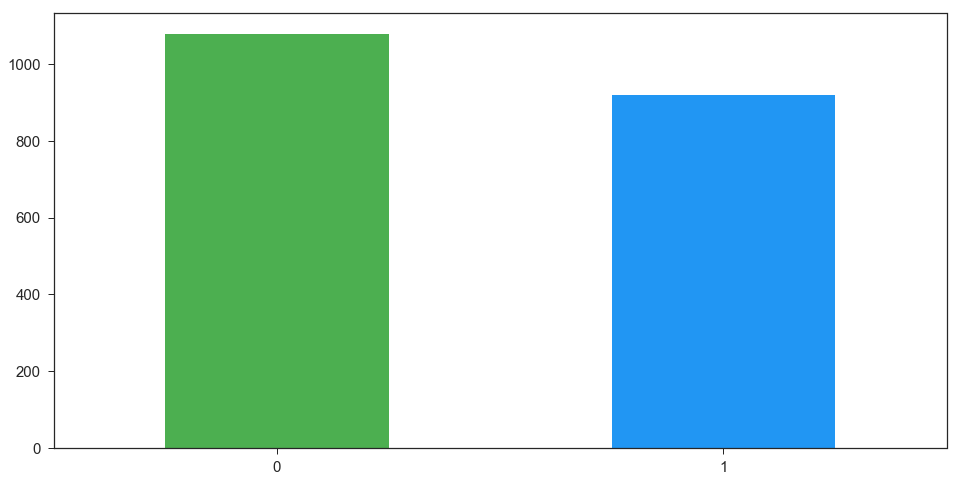

In [8]:
#matplot lib chart of target
nn_org_df.bi_flag.value_counts().plot(kind="bar", rot=0)

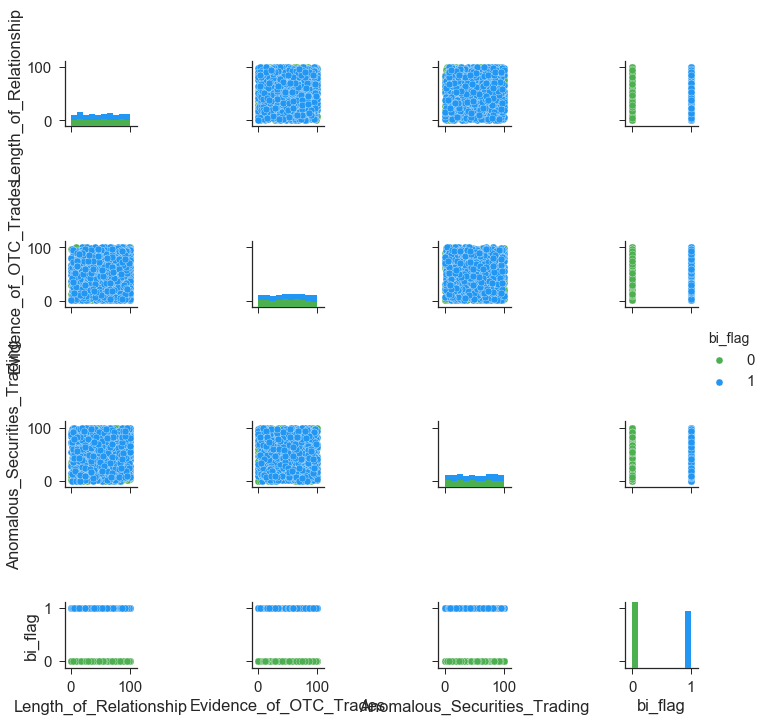

In [9]:
#biplots using seaborn package
sns.pairplot(nn_org_df[['Client_Type_of_Customer','Length_of_Relationship','Evidence_of_OTC_Trades','Anomalous_Securities_Trading','bi_flag']], hue='bi_flag')




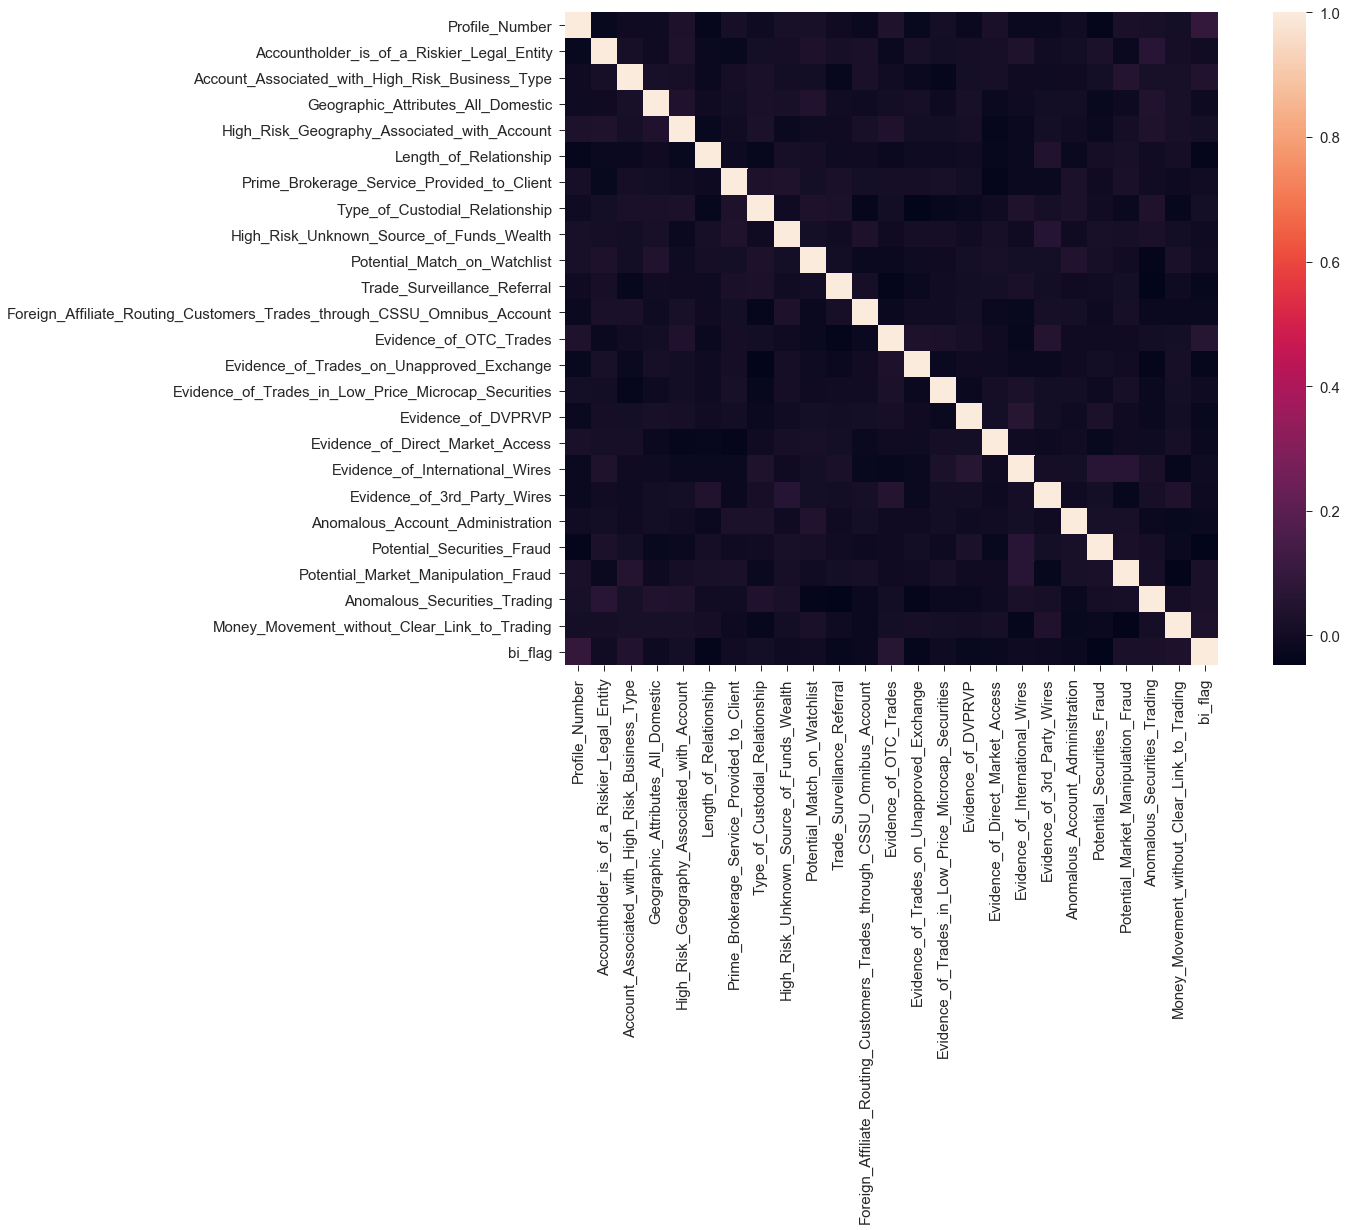

In [7]:
#corrolation matrix and covariance matrix 
corr_mat = nn_org_df.corr() 
fig, ax = plt.subplots(figsize=(20, 12)) 
sns.heatmap(corr_mat, vmax=1.0, square=True, ax=ax);

# Modeling Starts Here (Mannual)

In [10]:
#function to create dummy variables for each level of each categorical variable
def encode(series): 
  return pd.get_dummies(series.astype(str))

In [11]:
print(nn_org_df)

      Profile_Number Client_Type_of_Customer  \
0                  1                       A   
1                  2                       B   
2                  3                       D   
3                  4                       C   
4                  5                       A   
5                  6                       B   
6                  7                       D   
7                  8                       C   
8                  9                       A   
9                 10                       B   
10                11                       D   
11                12                       C   
12                13                       A   
13                14                       B   
14                15                       D   
15                16                       C   
16                17                       A   
17                18                       B   
18                19                       D   
19                20                    

In [12]:
#create dummy from client type
train_x = pd.get_dummies(nn_org_df.Client_Type_of_Customer)

#bind all columns we want to include in model dataframe into pandas
train_x = pd.concat([train_x, 
                     nn_org_df.Account_Associated_with_High_Risk_Business_Type,
                     nn_org_df.Geographic_Attributes_All_Domestic,
                     nn_org_df.High_Risk_Geography_Associated_with_Account,
                     nn_org_df.Length_of_Relationship,
                     nn_org_df.Type_of_Custodial_Relationship,
                     nn_org_df.Potential_Match_on_Watchlist,
                     nn_org_df.Evidence_of_OTC_Trades,
                     nn_org_df.Evidence_of_DVPRVP], axis=1)

#create dummy variable from target 
train_y = encode(nn_org_df.bi_flag)

In [13]:
#create training and validation samples 
train_size = 0.9

train_cnt = floor(train_x.shape[0] * train_size)
x_train = train_x.iloc[0:train_cnt].values
y_train = train_y.iloc[0:train_cnt].values
x_test = train_x.iloc[train_cnt:].values
y_test = train_y.iloc[train_cnt:].values

In [14]:
#define the graph for tensorflow(define the logic of the neurons)
def multilayer_perceptron(x, weights, biases, keep_prob):
    #add the weights and bias terms via metric multiplier (matrix multiplication)
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    #use the relu as the activiation function (modified sigmoid function)(0 if negative , y=x if > 0)
    layer_1 = tf.nn.relu(layer_1)
    #add a dropout rate 
    layer_1 = tf.nn.dropout(layer_1, keep_prob)
    #add output layer 
    out_layer = tf.matmul(layer_1, weights['out']) + biases['out']
    return out_layer


In [15]:
#model details 

#10 hidden layer nodes
n_hidden_1 = 10

#number of independent variables to include in the model 
n_input = train_x.shape[1]

#number of classes in the target(used for softmax functionality)
n_classes = train_y.shape[1]

#set initial weights of the hidden layer nodes and output nodes
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'out': tf.Variable(tf.random_normal([n_hidden_1, n_classes]))
}

#bias to introduce into the hidden layer and output layer 
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

#define the keep rate for the dropout parameter
keep_prob = tf.placeholder("float")

In [16]:
#define tuning parameters 

#total training epochs
training_epochs = 5000

#display the output from the model build every 1000 epochs (5 total times model updates will be printed to screen)
display_step = 1000

#number of datapoints to process at each iteration (at each iteration, the number of datapoints you want to consider)
#for each forward propogation, we only consider 32 data points (calculates gradient descent based on 8 , then updates parameters)
batch_size = 32

#defining the format of the x and y values (and provide dimensions of x and y)
#note: first dimension is really defined by the batch size (number of rows)
x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])

In [17]:
#genearte model grid / function to use
predictions = multilayer_perceptron(x, weights, biases, keep_prob)

In [18]:
#defining cost/loss and omptimizer  (you can use tensor flow classifers as loss functions as well)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=predictions, labels=y))

#optimize the NN to minimze the cost associated with the predictions 
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [19]:
#start a tensflow session and run the model
with tf.Session() as sess:
    
    #Global variable initializer assigns values/operations to the tensor variables
    sess.run(tf.global_variables_initializer())
    
    #run model across all 5000 epoches
    for epoch in range(training_epochs):
        #initalize cost function (starting at 0)
        avg_cost = 0.0
        
        #define total loops required in each epoch (based on batch size(rows per iteration))
        total_batch = int(len(x_train) / batch_size)
        
        #split rows from the training array and target array into bataches of 32 rows  
        x_batches = np.array_split(x_train, total_batch)
        y_batches = np.array_split(y_train, total_batch)
        
        for i in range(total_batch):
            
            #take the first batch of x and y values 
            batch_x, batch_y = x_batches[i], y_batches[i]
            
            #run tensorflow session, 
            _, c = sess.run([optimizer, cost], 
                            #feed function defining the x and y values to be used in the model 
                            #dropout rate defined by keep_prob
                            feed_dict={
                                x: batch_x, 
                                y: batch_y, 
                                keep_prob: 0.8
                            })
            
            #add the loss associated with the model to the avg_cost (which is why its divided by total_batch)
            avg_cost += c / total_batch
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost=", \
                "{:.9f}".format(avg_cost))
    print("Optimization Finished!")
    
    #check if the predicted value is equal to the actual values 
    correct_prediction = tf.equal(tf.argmax(predictions, 1), tf.argmax(y, 1))
    
    #determine model accuracy 
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print("Accuracy:", accuracy.eval({x: x_test, y: y_test, keep_prob: 1.0}))

Epoch: 0001 cost= 93.837162903
Epoch: 1001 cost= 0.684813068
Epoch: 2001 cost= 0.677372975
Epoch: 3001 cost= 0.667072471
Epoch: 4001 cost= 0.668655995
Optimization Finished!
Accuracy: 0.535


# Next Steps: Use TF Frameworks such as DNNClassifier and LinearClassifier